In [1]:
import json
import pickle
from itertools import chain

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

from neuron import h
from dlutils import utils
from dlutils.cell import Cell, branch_order
from dlutils.synapse import AMPANMDAExp2Synapse
from dlutils.spine import Spine

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
    103 pdb.set_trace()
    104 
--> 105 import sys
    106 embedded = True if 'hoc' in sys.modules else False
    107 

ipdb> c


### General parameters

In [2]:
optimization_folder = '/Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/'

# config_file = 'synaptic_cooperativity_thorny_passive.json'
config_file = 'synaptic_cooperativity_thorny_active_with_TTX.json'
# config_file = 'synaptic_cooperativity_thorny_active.json'
# config_file = 'synaptic_cooperativity_a-thorny_passive.json'
# config_file = 'synaptic_cooperativity_a-thorny_active_with_TTX.json'
# config_file = 'synaptic_cooperativity_a-thorny_active_with_TTX_without_NMDA.json'
# config_file = 'synaptic_cooperativity_a-thorny_active.json'
config = json.load(open(config_file, 'r'))

cell_type = config['cell_type']
prefix = cell_type[0].upper() + cell_type[1:]
base_folder = optimization_folder + prefix + '/' + config['cell_name'] + '/' + config['optimization_run'] + '/'
swc_file = config['swc_file']
cell_name = config['cell_name'] + '_'
individual = config['individual']

swc_file = base_folder + swc_file
params_file = base_folder + 'individual_{}.json'.format(individual)
config_file = base_folder + 'parameters.json'

passive = config['passive']
with_TTX = config['with_TTX']
replace_axon = True
add_axon_if_missing = True
parameters = json.load(open(params_file, 'r'))
mechanisms = utils.extract_mechanisms(config_file, cell_name)
sim_pars = pickle.load(open(base_folder + 'simulation_parameters.pkl','rb'))
replace_axon = sim_pars['replace_axon']
add_axon_if_missing = not sim_pars['no_add_axon']

### Functions used to describe the removal of the Mg block from the NMDA synapse

#### Maex & De Schutter
Maex, R., & De Schutter, E. (1998). Synchronization of Golgi and granule cell firing in a detailed network model of the cerebellar granule cell layer. Journal of Neurophysiology, 80(5), 2521–2537. http://doi.org/10.1152/jn.1998.80.5.2521

#### Jahr & Stevens
Jahr, C. E., & Stevens, C. F. (1990). A quantitative description of NMDA receptor-channel kinetic behavior. The Journal of Neuroscience, 10(6), 1830–1837.

Jahr, C. E., & Stevens, C. F. (1990). Voltage dependence of NMDA-activated macroscopic conductances predicted by single-channel kinetics. The Journal of Neuroscience, 10(9), 3178–3182. http://doi.org/10.1523/JNEUROSCI.10-09-03178.1990

#### Harnett
Harnett, M. T., Makara, J. K., Spruston, N., Kath, W. L., & Magee, J. C. (2012). Synaptic amplification by dendritic spines enhances input cooperativity. Nature, 491(7425), 599–602. http://doi.org/10.1038/nature11554

There is a mistake in the definition of the Mg removal function: the units of the expression found in the paper are incorrect. The correct function is the one found here and is actually also found in the second of Jahr & Stevens's papers (equation 5).

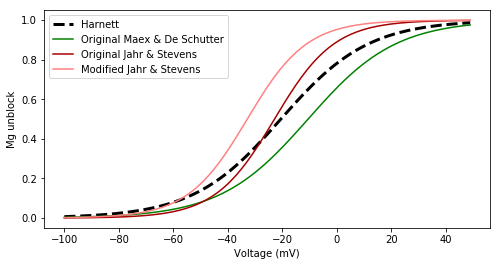

In [3]:
v = np.arange(-100, 50)
extMgConc = config['NMDA']['extMgConc']

mg_maex_orig = lambda v: 1. / (1. + 0.2801 * extMgConc * np.exp(-0.062 * (v - 10)))

mg_jahr_stevens_orig = lambda v: 1. / (1 + (extMgConc / 9.888) * np.exp(0.09137 * (2.222 - v)))

mg_harnett = lambda v: 1. / (1. + (extMgConc / 3.57) * np.exp(-0.062 * v))

plt.figure(figsize=(8,4))
plt.plot(v, mg_harnett(v), 'k--', lw=3, label='Harnett')
plt.plot(v, mg_maex_orig(v), color=[0,.5,0], label='Original Maex & De Schutter')

if config['NMDA']['model'] == 'MDS':
    alpha_vspom = config['NMDA']['alpha_vspom'] # -0.124
    v0_block    = config['NMDA']['v0_block']    # -10
    eta         = config['NMDA']['eta']         # 0.02801
    mg_maex_mod = lambda v: 1. / (1. + eta * extMgConc * np.exp(alpha_vspom * (v - v0_block)))
    plt.plot(v, mg_maex_mod(v), color=[.5,1,.5], label='Modified Maex & De Schutter')

plt.plot(v, mg_jahr_stevens_orig(v), color=[.65,0,0], label='Original Jahr & Stevens')

if config['NMDA']['model'] == 'JS':
    Kd    = config['NMDA']['Kd']    # (mM)
    gamma = config['NMDA']['gamma'] # (mV^-1)
    sh    = config['NMDA']['sh']    # (mV)
    mg_jahr_stevens_mod = lambda v: 1. / (1 + (extMgConc / Kd) * np.exp(gamma * (sh - v)))
    plt.plot(v, mg_jahr_stevens_mod(v), color=[1,.5,.5], label='Modified Jahr & Stevens')

plt.xlabel('Voltage (mV)')
plt.ylabel('Mg unblock')
plt.legend(loc='best');

### Instantiate the cell

In [4]:
cell = Cell('CA3_cell_%d' % int(np.random.uniform()*1e5), swc_file, parameters, mechanisms)
cell.instantiate(replace_axon, add_axon_if_missing, force_passive=passive, TTX=with_TTX)
section_num = config['section_num']
section = cell.morpho.apic[section_num]
Ra = section.Ra * config['Ra_neck_coeff']
print('Branch order of section {}: {}.'.format(section.name(), branch_order(section)))

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed
Branch order of section CA3_cell_23454[0].apic[14]: 7.


### Instantiate the spines

In [5]:
# in the Harnett paper, the head is spherical with a diameter of 0.5 um: a cylinder
# with diameter and length equal to 0.5 has the same (outer) surface area as the sphere
head_L = config['spine']['head_L']           # [um]
head_diam = config['spine']['head_diam']     # [um]
neck_L = config['spine']['neck_L']           # [um]
neck_diam = config['spine']['neck_diam']     # [um]
spine_distance = config['spine_distance']    # [um] distance between neighboring spines
n_spines = config['n_spines']                # number of spines
L = spine_distance * (n_spines - 1)
norm_L = L / section.L

spine_loc = config['spine_loc']
start, stop = spine_loc + norm_L/2 * np.array([-1,1])
if start < 0:
    start = 0
    stop = start + norm_L
if stop > 1:
    stop = 1
    start = stop - norm_L
spines = [Spine(section, x, head_L, head_diam, neck_L, neck_diam, Ra, i) \
            for i,x in enumerate(np.linspace(start, stop, n_spines))]

for spine in spines:
    spine.instantiate()

#### Check the location of the spines in terms of distinct segments

In [6]:
segments = [section(spines[0]._sec_x)]
segments_idx = [[0]]
for i,spine in enumerate(spines[1:]):
    if section(spine._sec_x) == segments[-1]:
        segments_idx[-1].append(i+1)
    else:
        segments.append(section(spine._sec_x))
        segments_idx.append([i+1])
if len(segments_idx) == 1:
    print('All spines are connected to the same segment.')
elif len(segments_idx) == n_spines:
    print('Each spine is connected to a different segment on the dendritic branch.')
else:
    for group in segments_idx:
        if len(group) > 1:
            print('Spines {} are connected to the same segment.'.format(group))
        else:
            print('Spine {} is connected to a distinct segment.'.format(group[0]))

Spines [0, 1, 2, 3] are connected to the same segment.
Spines [4, 5, 6, 7] are connected to the same segment.
Spine 8 is connected to a distinct segment.


#### Show where the spines are located on the dendritic tree

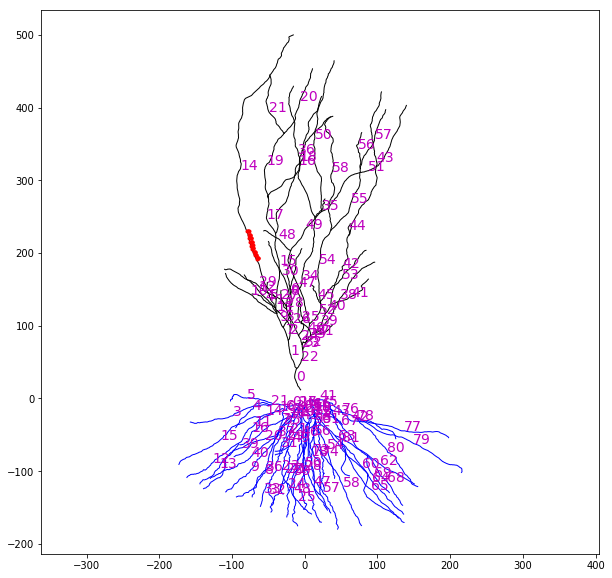

In [7]:
plt.figure(figsize=(10,10))
for sec in chain(cell.morpho.apic, cell.morpho.basal):
    if sec in cell.morpho.apic:
        color = 'k'
    else:
        color = 'b'
    lbl = sec.name().split('.')[1].split('[')[1][:-1]
    n = sec.n3d()
    sec_coords = np.zeros((n,2))
    for i in range(n):
        sec_coords[i,:] = np.array([sec.x3d(i), sec.y3d(i)])
    middle = int(n / 2)
    plt.text(sec_coords[middle,0], sec_coords[middle,1], lbl, \
             fontsize=14, color='m')
    plt.plot(sec_coords[:,0], sec_coords[:,1], color, lw=1)
for spine in spines:
    plt.plot(spine._points[:,0], spine._points[:,1], 'r.')
plt.axis('equal');

### Insert a synapse into each spine

In [8]:
MG_MODELS = {'MDS': 1, 'HRN': 2, 'JS': 3}
Mg_unblock_model = config['NMDA']['model']

E = 0        # [mV]

AMPA_taus = config['AMPA']['time_constants']
NMDA_taus = config['NMDA']['time_constants']
weights = np.array([config['AMPA']['weight'], config['NMDA']['weight']])

print('AMPA:')
print('    tau_rise = {:.3f} ms'.format(AMPA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(AMPA_taus['tau2']))
print('NMDA:')
print('    tau_rise = {:.3f} ms'.format(NMDA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(NMDA_taus['tau2']))

synapses = [AMPANMDAExp2Synapse(spine.head, 1, E, weights, AMPA = AMPA_taus, \
                                NMDA = NMDA_taus) for spine in spines]

for syn in synapses:
    syn.nmda_syn.mg_unblock_model = MG_MODELS[Mg_unblock_model]
    if Mg_unblock_model == 'MDS':
        syn.nmda_syn.alpha_vspom = config['NMDA']['alpha_vspom']
        syn.nmda_syn.v0_block = config['NMDA']['v0_block']
        syn.nmda_syn.eta = config['NMDA']['eta']
    elif Mg_unblock_model == 'JS':
        syn.nmda_syn.Kd = config['NMDA']['Kd']
        syn.nmda_syn.gamma = config['NMDA']['gamma']
        syn.nmda_syn.sh = config['NMDA']['sh']

if Mg_unblock_model == 'MDS':
    print('\nUsing Maex & De Schutter Mg unblock model. Modified parameters:')
    print('       alpha = {:.3f} 1/mV'.format(synapses[0].nmda_syn.alpha_vspom))
    print('    v0_block = {:.3f} mV'.format(synapses[0].nmda_syn.v0_block))
    print('         eta = {:.3f}'.format(synapses[0].nmda_syn.eta))
elif Mg_unblock_model == 'JS':
    print('\nUsing Jahr & Stevens Mg unblock model. Modified parameters:')
    print('          Kd = {:.3f} 1/mV'.format(synapses[0].nmda_syn.Kd))
    print('       gamma = {:.3f} 1/mV'.format(synapses[0].nmda_syn.gamma))
    print('          sh = {:.3f} mV'.format(synapses[0].nmda_syn.sh))
elif Mg_unblock_model == 'HRN':
    print('\nUsing Harnett Mg unblock model with default parameters.')

AMPA:
    tau_rise = 0.100 ms
   tau_decay = 1.000 ms
NMDA:
    tau_rise = 1.000 ms
   tau_decay = 50.000 ms

Using Jahr & Stevens Mg unblock model. Modified parameters:
          Kd = 9.888 1/mV
       gamma = 0.091 1/mV
          sh = -7.778 mV


#### Make the recorders

In [9]:
rec = {}
for lbl in 't','Vsoma':
    rec[lbl] = h.Vector()
rec['t'].record(h._ref_t)
rec['Vsoma'].record(cell.morpho.soma[0](0.5)._ref_v)
for i,spine in enumerate(spines):
    rec['Vdend-{}'.format(i)] = h.Vector()
    rec['Vspine-{}'.format(i)] = h.Vector()
    rec['IAMPA-{}'.format(i)] = h.Vector()
    rec['gAMPA-{}'.format(i)] = h.Vector()
    rec['INMDA-{}'.format(i)] = h.Vector()
    rec['gNMDA-{}'.format(i)] = h.Vector()
    rec['MgBlock-{}'.format(i)] = h.Vector()
    rec['Vdend-{}'.format(i)].record(spine._sec(spine._sec_x)._ref_v)
    rec['Vspine-{}'.format(i)].record(spine.head(0.5)._ref_v)
    rec['IAMPA-{}'.format(i)].record(synapses[i].syn[0]._ref_i)
    rec['gAMPA-{}'.format(i)].record(synapses[i].syn[0]._ref_g)
    rec['INMDA-{}'.format(i)].record(synapses[i].syn[1]._ref_i)
    rec['gNMDA-{}'.format(i)].record(synapses[i].syn[1]._ref_g)
    rec['MgBlock-{}'.format(i)].record(synapses[i].syn[1]._ref_mgBlock)

### Compute somatic and dendritic input resistance

  Somatic RMP: -68.3 mV.
Dendritic RMP: -72.1 mV.
  Somatic input resistance: 25 MOhm.
Dendritic input resistance: 310 MOhm.


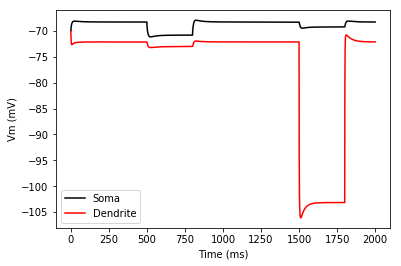

In [10]:
stim = {'soma': h.IClamp(cell.morpho.soma[0](0.5)), 'dend': h.IClamp(section(spines[0]._sec_x))}
for i,k in enumerate(stim):
    stim[k].delay = 500 + i*1000
    stim[k].amp = -0.1
    stim[k].dur = 300
h.tstop = 2000
h.run()
t = np.array(rec['t'])
V = {'soma': np.array(rec['Vsoma']), 'dend': np.array(rec['Vdend-0'])}
R = {}
for k in V:
    idx, = np.where((t > stim[k].delay) & (t < stim[k].delay + stim[k].dur))
    V0 = V[k][idx[0]-10]
    V1 = V[k][idx[-1]]
    R[k] = (V1 - V0) / stim[k].amp
    stim[k].amp = 0
    stim[k].dur = 0
    stim[k].delay = 1e6
print('  Somatic RMP: {:.1f} mV.'.format(V['soma'][-1]))
print('Dendritic RMP: {:.1f} mV.'.format(V['dend'][-1]))
print('  Somatic input resistance: {:.0f} MOhm.'.format(R['soma']))
print('Dendritic input resistance: {:.0f} MOhm.'.format(R['dend']))

plt.plot(t, V['soma'], 'k', label='Soma')
plt.plot(t, V['dend'], 'r', label='Dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend(loc='best');

#### Compute the presynaptic spike times

In [11]:
t0 = 1000.
dt = 1000.
with_somatic_current_injection = False
if with_somatic_current_injection:
    spike_times = [np.sort(t0 + n_spines * dt - np.arange(i) * dt) for i in range(n_spines+1, 0, -1)]
    spike_times = spike_times[:-1]
else:
    spike_times = [np.sort(t0 + (n_spines - 1) * dt - np.arange(i) * dt) for i in range(n_spines, 0, -1)]

if 'spike_dt' in config:
    spike_dt = config['spike_dt']
else:
    spike_dt = 0.3
for i in range(n_spines):
    for j in range(len(spike_times[i])):
        spike_times[i][j] += i * spike_dt

for syn, spks in zip(synapses, spike_times):
    syn.set_presynaptic_spike_times(spks)
    
if with_somatic_current_injection:
    stim['soma'].amp = 0.06
    stim['soma'].dur = 100
    stim['soma'].delay = spike_times[0][-1]

In [12]:
spike_times

[array([1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000., 9000.]),
 array([2000.3, 3000.3, 4000.3, 5000.3, 6000.3, 7000.3, 8000.3, 9000.3]),
 array([3000.6, 4000.6, 5000.6, 6000.6, 7000.6, 8000.6, 9000.6]),
 array([4000.9, 5000.9, 6000.9, 7000.9, 8000.9, 9000.9]),
 array([5001.2, 6001.2, 7001.2, 8001.2, 9001.2]),
 array([6001.5, 7001.5, 8001.5, 9001.5]),
 array([7001.8, 8001.8, 9001.8]),
 array([8002.1, 9002.1]),
 array([9002.4])]

#### Run the simulation

In [13]:
h.cvode_active(1)
h.tstop = t0 + n_spines * dt
if with_somatic_current_injection:
    h.tstop += dt
h.run()

0.0

#### Get the data from the recorders

In [14]:
t = np.array(rec['t'])
iampa = np.array([np.array(rec['IAMPA-{}'.format(i)])*1e3 for i in range(n_spines)])
inmda = np.array([np.array(rec['INMDA-{}'.format(i)])*1e3 for i in range(n_spines)])
gampa = np.array([np.array(rec['gAMPA-{}'.format(i)])*1e3 for i in range(n_spines)])
gnmda = np.array([np.array(rec['gNMDA-{}'.format(i)])*1e3 for i in range(n_spines)])
MgBlock = np.array([np.array(rec['MgBlock-{}'.format(i)])for i in range(n_spines)])
Vspine = np.array([np.array(rec['Vspine-{}'.format(i)]) for i in range(n_spines)])
Vdend = np.array([np.array(rec['Vdend-{}'.format(i)]) for i in range(n_spines)])
Vsoma = np.array(rec['Vsoma'])

In [15]:
if with_somatic_current_injection:
    fig,ax = plt.subplots(1, 1, figsize=(10,6))
    t0 = stim['soma'].delay
    idx, = np.where((t > spike_times[0][-2] - 20) & (t < spike_times[0][-2] + 150))
    ax.plot(t[idx] - spike_times[0][-2], Vsoma[idx], 'k', lw=1, label='Without somatic stimulus')
    idx, = np.where((t > spike_times[0][-1] - 20) & (t < spike_times[0][-1] + 150))
    ax.plot(t[idx] - spike_times[0][-1], Vsoma[idx], 'r', lw=1, label='With somatic stimulus')
    yl = ax.get_ylim()
    dy = yl[1] - yl[0]
    ax.plot([0, stim['soma'].dur], yl[0] + np.zeros(2), color=[.8,.8,1], lw=5)
    ax.text(stim['soma'].dur/2, yl[0] - dy/30, 'SOMATIC STIMULUS', horizontalalignment='center', verticalalignment='top')
    plt.xlabel('Time since presynaptic spike arrival (ms)')
    plt.ylabel('Membrane voltage (mV)')
    ax.set_ylim([yl[0] - dy/10, yl[1]])
    ax.legend(loc='best');

#### Measure the amplitude ratio when the input is synaptic

AR = 9.487
 Dendritic input resistance: 310 MOhm.
Spine neck input resistance: 2634 MOhm.


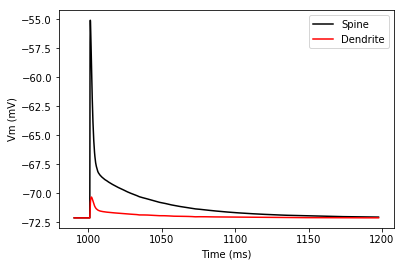

In [16]:
idx, = np.where((t > 990) & (t < 1200))
EPSP_spine = np.max(Vspine[0,idx]) - Vspine[0,-1]
EPSP_dend = np.max(Vdend[0,idx]) - Vdend[0,-1]
AR = EPSP_spine / EPSP_dend
R['neck'] = (AR - 1) * R['dend']
print('AR = {:.3f}'.format(AR))
print(' Dendritic input resistance: {:.0f} MOhm.'.format(R['dend']))
print('Spine neck input resistance: {:.0f} MOhm.'.format(R['neck']))
plt.plot(t[idx], Vspine[0,idx], 'k', label='Spine')
plt.plot(t[idx], Vdend[0,idx], 'r', label='Dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend(loc='best');

#### Measure the dendritic EPSPs and the NMDA conductance values

In [17]:
V_dend_pks = []
V_soma_pks = []
G_NMDA_pks = []
G_AMPA_pks = []
for i,spk in enumerate(spike_times[0][:n_spines]):
    idx, = np.where((t > spk) & (t < spk + 200))
    V_dend_pks.append(np.argmax(Vdend[0,idx]) + idx[0])
    V_soma_pks.append(np.argmax(Vsoma[idx]) + idx[0])
    G_NMDA_pks.append(np.argmax(gnmda[0,idx] * MgBlock[0,idx]) + idx[0])
    G_AMPA_pks.append(np.argmax(gampa[0,idx]) + idx[0])
dV_dend = Vdend[0,V_dend_pks] - Vdend[0,-1]
dV_soma = Vsoma[V_soma_pks] - Vsoma[-1]
dG_NMDA = gnmda[0,G_NMDA_pks] * MgBlock[0,G_NMDA_pks]
dG_AMPA = gampa[0,G_AMPA_pks]

#### Plot the time course of the dendritic EPSPs and the NMDA conductance for increasing number of synaptic inputs

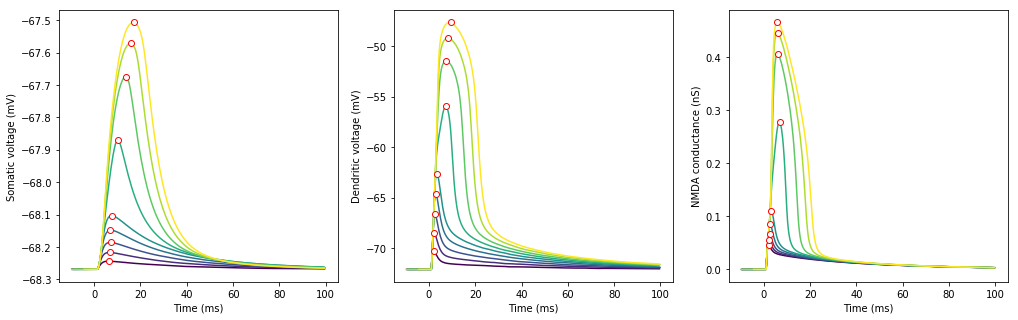

In [18]:
cmap = plt.get_cmap('viridis', n_spines)
window = [10, 100]
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(17,5), sharex=True)
for i,spk in enumerate(spike_times[0][:n_spines]):
    idx = (t > spk - window[0]) & (t < spk + window[1])
    ax1.plot(t[idx] - spk, Vsoma[idx], color=cmap(i))
    ax2.plot(t[idx] - spk, Vdend[0,idx], color=cmap(i))
    ax3.plot(t[idx] - spk, gnmda[0,idx] * MgBlock[0,idx], color=cmap(i))
for i,spk in enumerate(spike_times[0][:n_spines]):
    ax1.plot(t[V_soma_pks[i]] - spk, Vsoma[V_soma_pks[i]], 'ro', markerfacecolor='w', linewidth=2)
    ax2.plot(t[V_dend_pks[i]] - spk, Vdend[0,V_dend_pks[i]], 'ro', markerfacecolor='w', linewidth=2)
    ax3.plot(t[G_NMDA_pks[i]] - spk, gnmda[0,G_NMDA_pks[i]] * MgBlock[0,G_NMDA_pks[i]], 'ro', markerfacecolor='w', linewidth=2)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Somatic voltage (mV)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Dendritic voltage (mV)')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('NMDA conductance (nS)');

#### Plot the time course of the EPSP at each spine for increasing number of synaptic inputs

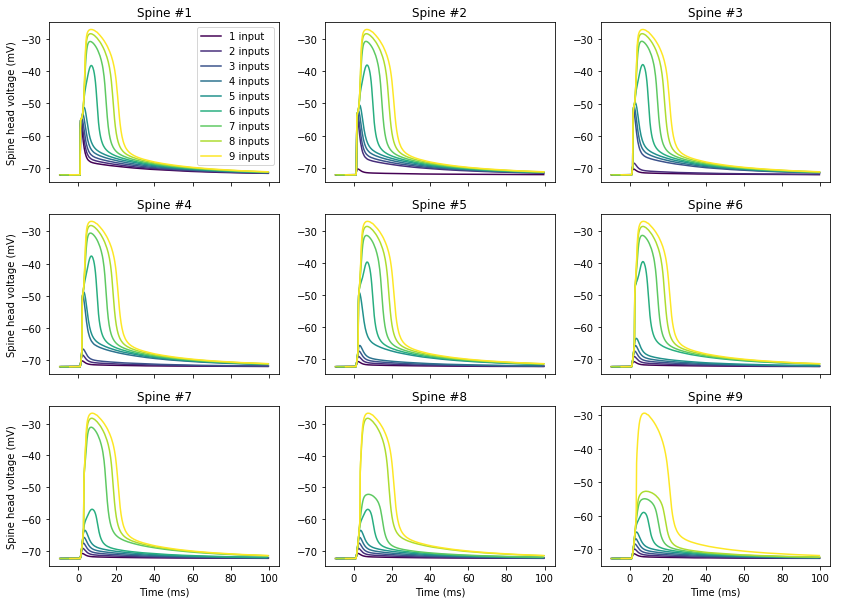

In [19]:
cmap = plt.get_cmap('viridis', n_spines)
window = [10, 100]
fig,ax = plt.subplots(3, 3, figsize=(14,10), sharex=True)
for n,spk in enumerate(spike_times[0][:n_spines]):
    idx = (t > spk - window[0]) & (t < spk + window[1])
    for i in range(3):
        for j in range(3):
            k = i*3 + j
            lbl = '{} input'.format(n+1) if n == 0 else '{} inputs'.format(n+1)
            ax[i,j].plot(t[idx] - spk, Vspine[k, idx], color=cmap(n), label=lbl)
            ax[i,j].set_title('Spine #{}'.format(k+1))
        ax[i,0].set_ylabel('Spine head voltage (mV)')
        ax[2,i].set_xlabel('Time (ms)')
ax[0,0].legend(loc='best');

#### Plot the time course of the NMDA conductance in each spine for increasing number of synaptic inputs

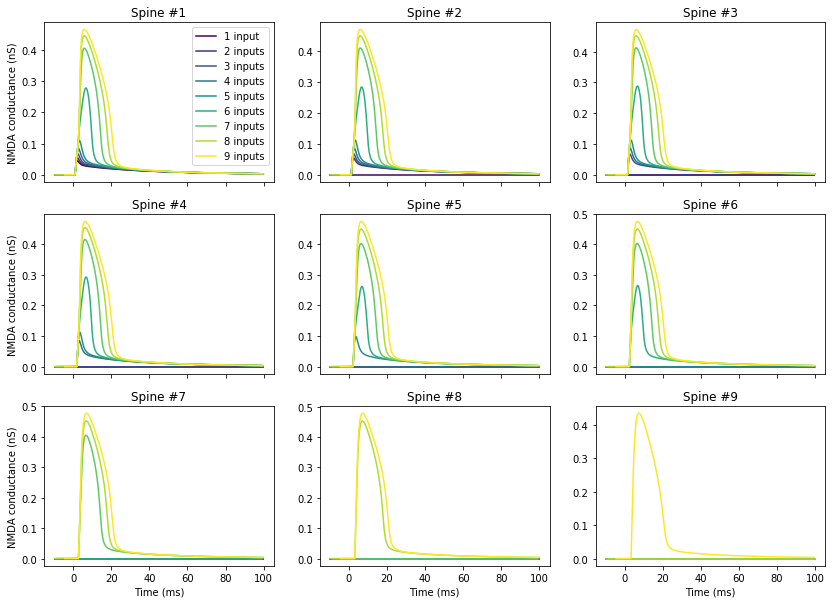

In [20]:
cmap = plt.get_cmap('viridis', n_spines)
window = [10, 100]
fig,ax = plt.subplots(3, 3, figsize=(14,10), sharex=True)
for n,spk in enumerate(spike_times[0][:n_spines]):
    idx = (t > spk - window[0]) & (t < spk + window[1])
    for i in range(3):
        for j in range(3):
            k = i*3 + j
            lbl = '{} input'.format(n+1) if n == 0 else '{} inputs'.format(n+1)
            ax[i,j].plot(t[idx] - spk, gnmda[k, idx] * MgBlock[k, idx], color=cmap(n), label=lbl)
            ax[i,j].set_title('Spine #{}'.format(k+1))
        ax[i,0].set_ylabel('NMDA conductance (nS)')
        ax[2,i].set_xlabel('Time (ms)')
ax[0,0].legend(loc='best');

#### Plot the amplitude of the dendritic EPSPs and of the NMDA conductance as a function of the number of synaptic inputs

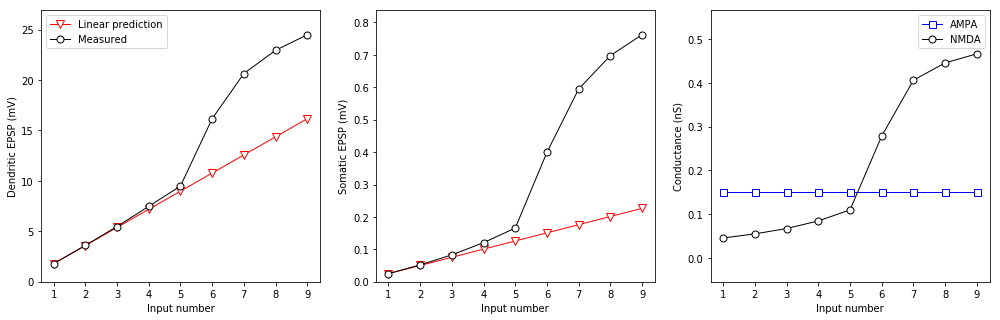

In [21]:
n = 1 + np.arange(n_spines)
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(17,5), sharex=True)
ax1.plot(n, n * dV_dend[0], 'rv-', lw=1, markerfacecolor='w', markersize=8, label='Linear prediction')
ax1.plot(n, dV_dend, 'ko-', lw=1, markerfacecolor='w', markersize=7, label='Measured')
ax2.plot(n, n * dV_soma[0], 'rv-', lw=1, markerfacecolor='w', markersize=8, label='Linear prediction')
ax2.plot(n, dV_soma, 'ko-', lw=1, markerfacecolor='w', markersize=7, label='Measured')
ax3.plot(n, dG_AMPA, 'bs-', lw=1, markerfacecolor='w', markersize=7, label='AMPA')
ax3.plot(n, dG_NMDA, 'ko-', lw=1, markerfacecolor='w', markersize=7, label='NMDA')
ax1.set_xlabel('Input number')
ax1.set_ylabel('Dendritic EPSP (mV)')
ax2.set_xlabel('Input number')
ax2.set_ylabel('Somatic EPSP (mV)')
ax3.set_xlabel('Input number')
ax3.set_ylabel('Conductance (nS)')
ax1.legend(loc='best')
ax3.legend(loc='best')
ax1.set_ylim([0, np.max([dV_dend[-1], dV_dend[0]*n_spines]) * 1.1])
ax2.set_ylim([0, np.max([dV_soma[-1], dV_soma[0]*n_spines]) * 1.1])
ax3.set_ylim([dG_NMDA[0] - 0.1, dG_NMDA[-1] + 0.1]);

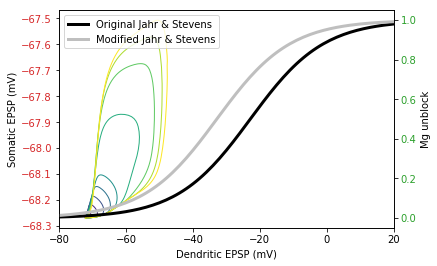

In [22]:
cmap = plt.get_cmap('viridis', n_spines)
window = [50,100]
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(v, mg_jahr_stevens_orig(v), color=[0,0,0], lw=3, label='Original Jahr & Stevens')
ax2.plot(v, mg_jahr_stevens_mod(v), color=[.75,.75,.75], lw=3, label='Modified Jahr & Stevens')
ax2.legend(loc='upper left')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylabel('Mg unblock')

for n,spk in enumerate(spike_times[0][:n_spines]):
    idx, = np.where((t > spk - window[0]) & (t < spk + window[1]))
    ax1.plot(Vdend[0,idx], Vsoma[idx], color=cmap(n), lw=1)
ax1.set_xlabel('Dendritic EPSP (mV)')
ax1.set_ylabel('Somatic EPSP (mV)')
ax1.tick_params(axis='y', labelcolor='tab:red')
plt.xlim([-80,20]);

#### Save the data